<center><font size="10">Mehta Purvil</font></center>
<br><center><font size="6">Github Username: purvilmehta06</font></center>
<br><center><font size="6">USC ID: 6104797766</font></center>

# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display, Markdown
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Constants

In [18]:
warnings.simplefilter('ignore')
headers = ['Feature', 'Mean', 'Median', 'Range', 'First quartiles', 'Third quartiles', 'Interquartile ranges']
data_file_path = '../data/CCPP/Folds5x2_pp.xlsx'

# Utility Functions

In [19]:
def plot_regression_line(train_x, train_y, feature, response, b_1, b_0, title, figsize):
    
    plt.figure(figsize = figsize)
    plt.scatter(train_x, train_y, s = 2)

    x_values = np.arange(train_x.min(), train_x.max())
    y_values = b_1*x_values + b_0
    regression_line = str(b_0) + '+' + feature + '*' + str(b_1)
    
    plt.plot(x_values, y_values, label= regression_line, color = 'black')
    plt.legend(loc = 'best', fontsize = 8)
    plt.grid()
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel(response)
    plt.show()
    
def plot_standard_residual(train_x, train_y, cook_dist, feature, response):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].scatter(train_x, cook_dist, s = 2)
    axs[0].set_xlabel(feature)
    axs[0].set_ylabel("Cook Distance")
    axs[0].grid()
    
    color = ['red' if x > 4/len(train_x) else '#1f77b4' for x in cook_dist]
    axs[1].scatter(train_x, train_y, c = color, s = 2)
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel(response)
    axs[1].grid()
    axs[1].legend(handles = [mpatches.Patch(color='red', label='Outlier')])
    plt.show()

def calculate_mse(model, train_x, train_y, test_x, test_y):
    
    pred_train = model.predict(train_x)
    train_mse = mean_squared_error(pred_train, train_y)
    pred_test = model.predict(test_x)
    test_mse = mean_squared_error(pred_test, test_y)
    return round(train_mse, 5), round(test_mse, 5)

def knn_regression(train_x, train_y, test_x, test_y):
    
    train_error = []
    test_errer = []
    min_test_error, best_k = 10**50, -1
    for k in range(1, 101):
        
        model = KNeighborsRegressor(n_neighbors = k)
        model.fit(train_x, train_y)
        
        pred_train = model.predict(train_x)
        pred_test = model.predict(test_x)
        
        train_mse = mean_squared_error(pred_train, train_y)
        test_mse = mean_squared_error(pred_test, test_y)
        
        train_error.append(train_mse)
        test_errer.append(test_mse)
        
        if (min_test_error > test_mse):
            min_test_error = test_mse 
            best_k = k
        
    return train_error, test_errer, best_k, round(min_test_error, 5)

def plot_test_train_knn_regression(axs, train_error, test_error, title):
    
    k = list(range(1, 101))
    k = [1/x for x in k]
    axs.plot(k, train_error, label = 'Training MSE')
    axs.plot(k, test_error, label = 'Testing MSE')
    axs.set_xlabel('1/k')
    axs.set_ylabel('MSE')
    axs.set_title(title)
    axs.grid()
    axs.legend()
    return axs

# Combined Cycle Power Plant Data Set

## [1a] Download Data

In [20]:
data = pd.read_excel(data_file_path)
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## [1b] Exploring the data

### i rows and columns

In [21]:
data_info = [["Total Rows", data.shape[0], "The row represents the sample or observations."], 
             ["Total Columns", data.shape[1], "The column represents features or attributes each observation has."]]
print(tabulate(data_info, tablefmt = 'grid'))

features = list(data.columns)
response = features[-1]
features = features[:-1]

+---------------+------+--------------------------------------------------------------------+
| Total Rows    | 9568 | The row represents the sample or observations.                     |
+---------------+------+--------------------------------------------------------------------+
| Total Columns |    5 | The column represents features or attributes each observation has. |
+---------------+------+--------------------------------------------------------------------+


### ii pairwise scatterplots of all the varianbles

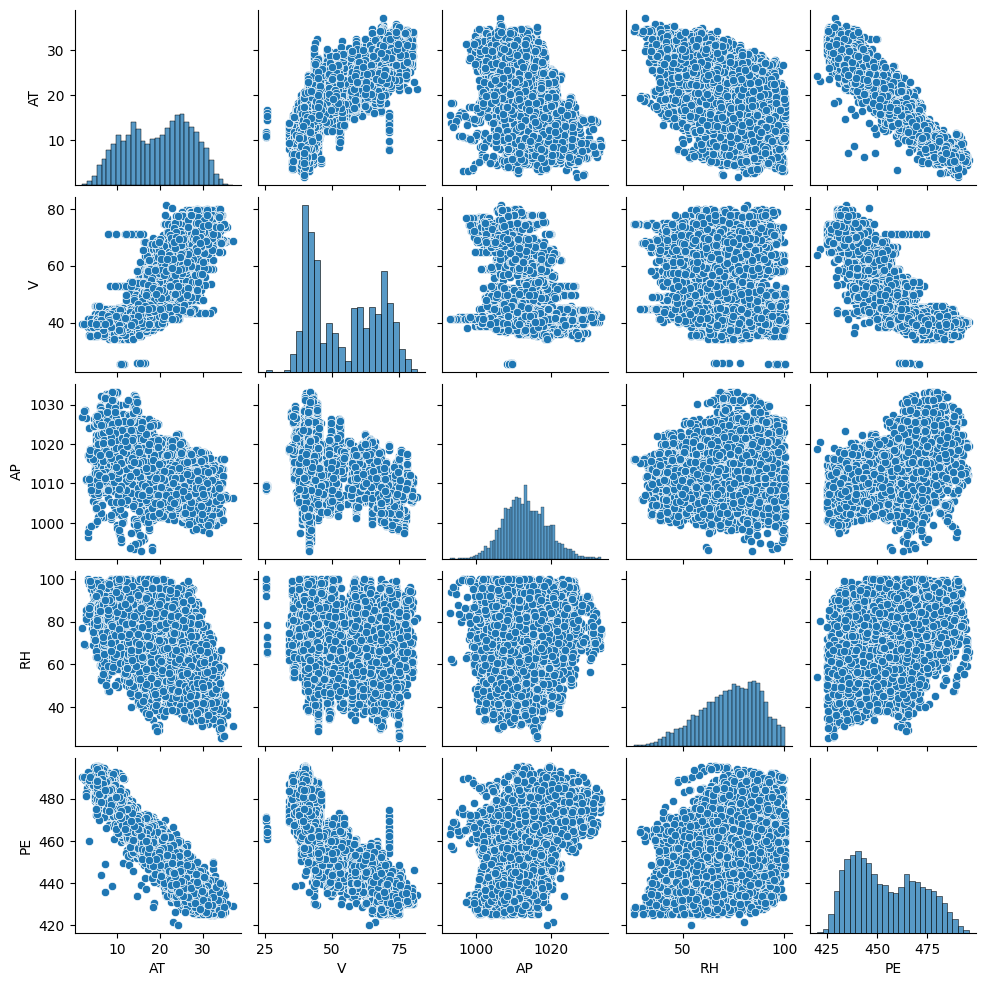

In [22]:
sns.pairplot(data = data, height = 2)

<font size="6">Findings</font></br>
* The scatter plots for PE vs AT, PE vs V and V vs AT have less variance as the data are very less spread accross the region. 
* In contrast to the above, the scatter plots of PE vs AP, PE vs RH etc has clearly spreaded accross the region. This would mean that the linear regression on using this features may have many outliers, i.e more RSS error

* Plotting correlation matrix to understand more better

In [23]:
correlation = data.corr()
correlation.style.background_gradient(cmap='coolwarm')

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


* As we can see from the above matrix that corelation between PE vs AP and PE vd RH is very low. Whereas the corelation between PE vs AT and PE vs V is too high.

### iii mean, the median, range, first and third quartiles, and interquartile ranges

In [24]:
stats = data.describe()
result = []
for feature in list(data.columns):
    result.append([feature, stats[feature]['mean'], stats[feature]['50%'], 
                   stats[feature]['max'] - stats[feature]['min'],
                   stats[feature]['25%'], stats[feature]['75%'], stats[feature]['75%'] - stats[feature]['25%']])
print(tabulate(result, headers = headers, tablefmt = 'grid'))

+-----------+-----------+----------+---------+-------------------+-------------------+------------------------+
| Feature   |      Mean |   Median |   Range |   First quartiles |   Third quartiles |   Interquartile ranges |
+===========+===========+==========+=========+===================+===================+========================+
| AT        |   19.6512 |   20.345 |   35.3  |           13.51   |             25.72 |                12.21   |
+-----------+-----------+----------+---------+-------------------+-------------------+------------------------+
| V         |   54.3058 |   52.08  |   56.2  |           41.74   |             66.54 |                24.8    |
+-----------+-----------+----------+---------+-------------------+-------------------+------------------------+
| AP        | 1013.26   | 1012.94  |   40.41 |         1009.1    |           1017.26 |                 8.16   |
+-----------+-----------+----------+---------+-------------------+-------------------+------------------

## [1c] Simple Linear Regression

<left><br><font size="6">Analysis: AT</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

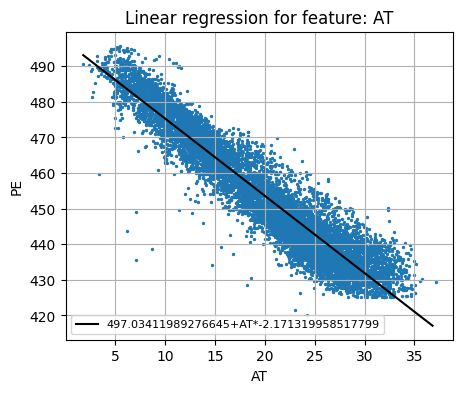

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:02   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341      0.156   3177.280      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

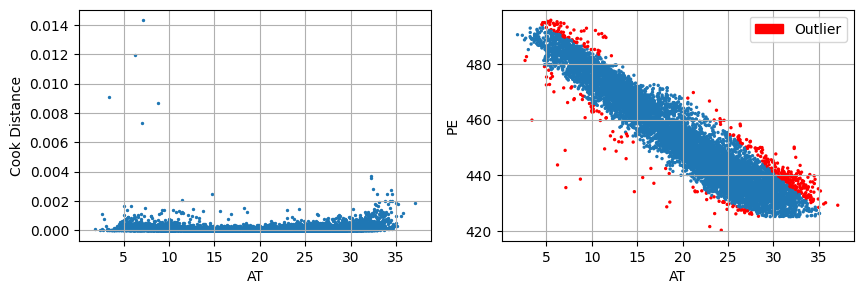

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 416 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.8989475964148236                                   |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: V</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

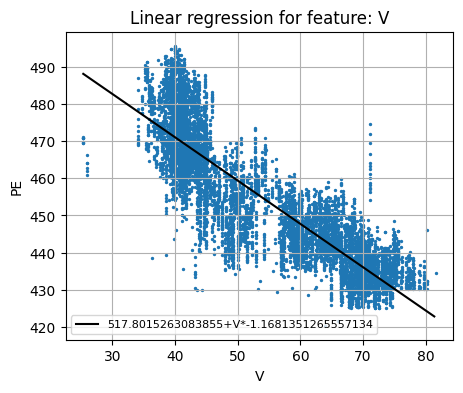

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:02   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015      0.378   1370.218      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

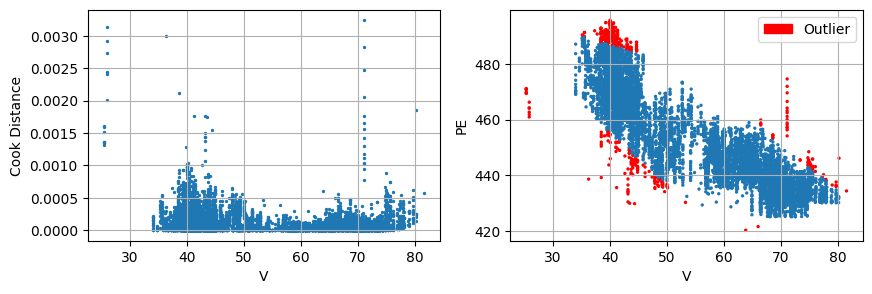

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 423 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.7565177870683979                                   |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: AP</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

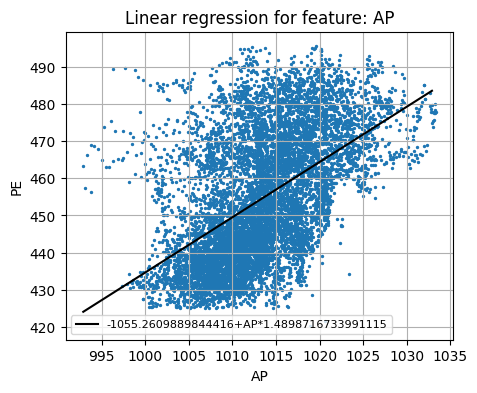

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:02   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610     25.459    -41.449      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

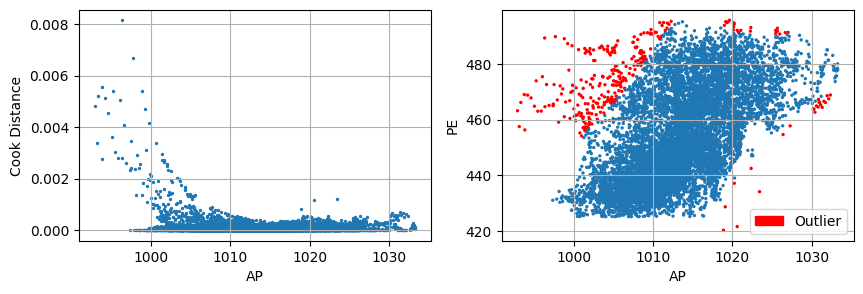

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 300 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.26876865641106784                                  |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: RH</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

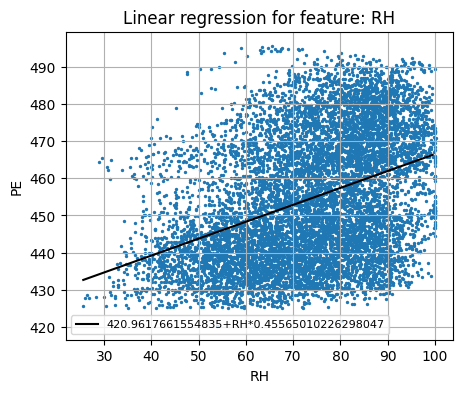

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:03   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    420.9618      0.823    511.676      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

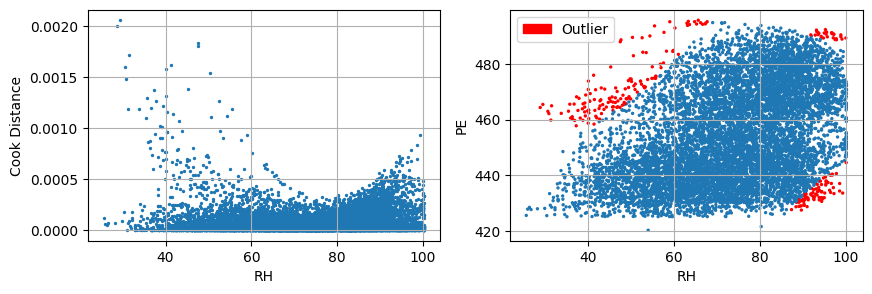

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 249 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.15193944023117445                                  |
+-----------+------------------------------------------------------+


In [43]:
single_regression_coeff = []
for i, feature in enumerate(features):
    
    display(Markdown('<left><br><font size="6">Analysis: {}</font></br></left>'.format(feature)))

    # linear regression fitting and parameter extraction
    model = smf.ols(formula = 'PE ~ ' + feature, data = data).fit()
    b_0, b_1, pValue = model.params[0], model.params[1], model.pvalues[1]
    
    # plotting regression line
    display(Markdown('<left><br><font size="5">1. Plotting regression line</font></br></left>'.format(feature)))
    plot_regression_line(data[feature], data[response], feature, 
                                response, b_1, b_0, "Linear regression for feature: " + feature, (5, 4))
    
    # printing summary
    display(Markdown('<left><br><font size="5">2. Summary of the model</font></br></left>'))
    print(model.summary())
    
    # check if there are any outliers 
    display(Markdown('<left><br><font size="5">3. Outlier Detection</font></br></left>'.format(feature)))
    influence = model.get_influence()
    cook_dist = influence.cooks_distance[0]
    plot_standard_residual(data[feature], data[response], cook_dist, feature, response)
    
    # comment on the model and its parameters
    display(Markdown('<left><br><font size="5">4. Findings</font></br></left>'.format(feature)))
    if (pValue < 0.05):
        pValue_comment = "pValue[x_1] = " + str(pValue) + " < 0.05, => Statistically Signicant"
    else:
        pValue_comment = "pValue[x_1] = " + str(pValue) + " >= 0.05, => Statistically Insignicant"
    
    # comment on outlier
    cook_dist = cook_dist > (4/data.shape[0])
    if sum(cook_dist):
        outlier_comment = str(sum(cook_dist)) + " outliers are present"
    else:
        outlier_comment = "There are no outliers present"
    
    # r^2 value calculation
    r2Value = model.rsquared
    single_regression_coeff.append(b_1)
    
    comments = [["P Value", pValue_comment], ["Outliers", outlier_comment], ["r^2 Value", r2Value]]
    print(tabulate(comments, tablefmt = 'grid', maxcolwidths = 100))
    
    
plt.show()

## [1d] Multiple Regression

In [28]:
# get the data
features = list(data.columns)
response, features = features[-1], features[:-1]


# splitting features from response
train_x = np.array(data[features])
train_x = sm.add_constant(train_x)
train_y = np.array(data[response])

# fitting up model
model = smf.ols(formula = 'PE ~ AT + V + AP + RH', data = data).fit()
multiple_regression_coeff = model.params[1:]

# summary of the model
display(Markdown('<br><font size="6">Summary of the model</font></br>'))
print(model.summary())

# null hypothesis analysis
display(Markdown('<br><font size="6">Null hypothesis Analysis</font></br>'))
print("Since the Pvalue for all variables are <0.05, all of them are statistically ", end = "")
print("significant and we should reject the null hypothesis")

<br><font size="6">Summary of the model</font></br>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:11:55   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.6093      9.749     46.634      0.0

<br><font size="6">Null hypothesis Analysis</font></br>

Since the Pvalue for all variables are <0.05, all of them are statistically significant and we should reject the null hypothesis


<font size="6">Findings</font></br>
1. t-value of all coefficients is significantly larger than the threshold value. This proves the quality of the hypothesis.  
2. $R^2$ value for this model is increased to $0.93$ compared to the previous models with the highest $R^2$ as $0.9$. This means that model is trained well with all the features rather than relying on a single feature. 

## [1e] 1c Compare to 1d

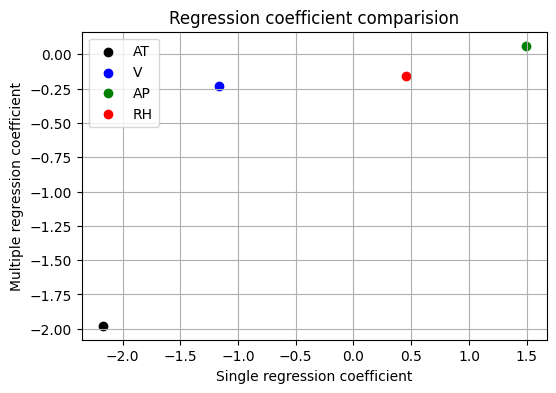

In [29]:
features = list(data.columns)[:-1]
c = ['black', 'blue', 'green', 'red']
plt.figure(figsize = (6, 4))
for i in range(len(multiple_regression_coeff)):
    plt.scatter(single_regression_coeff[i], multiple_regression_coeff[i], c = c[i], label = features[i])
plt.grid()
plt.legend()
plt.xlabel('Single regression coefficient')
plt.ylabel('Multiple regression coefficient')
plt.title('Regression coefficient comparision')
plt.show()

## [1f] Nonlinear Association

In [30]:
single_regression_coeff = []
for i, feature in enumerate(features):
    
    display(Markdown('<left><br><font size="6">Analysis: {}</font></br></left>'.format(feature)))    
    model = smf.ols(formula = 'PE ~ ' + feature + ' + I(' + feature + '**2)' + ' + I(' + feature + '**3)', 
                    data = data).fit()
    
    # printing summary
    display(Markdown('<left><br><font size="5">Summary of the model</font></br></left>'))
    print(model.summary())

<left><br><font size="6">Analysis: AT</font></br></left>

<left><br><font size="5">Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:12:03   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    492.7281      0.673    732.248      0.0

<left><br><font size="6">Analysis: V</font></br></left>

<left><br><font size="5">Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:12:03   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    554.1468      9.151     60.557      0.0

<left><br><font size="6">Analysis: AP</font></br></left>

<left><br><font size="5">Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:12:03   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0747      0.009      8.415      0.0

<left><br><font size="6">Analysis: RH</font></br></left>

<left><br><font size="5">Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:12:03   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    468.4135     10.545     44.422      0.0

<font size="6">Findings</font></br>
* The p-value of only the $V^2$ feature from the dataset showed Statistically Insignificant. P values for the rest of the features showed Statistically Significant importance, which means there is evidence of a nonlinear association between any of the predictors and the response.

## [1g] Interactions of Predictors

In [31]:
# linear regression fitting
f = "PE ~ AT + V + AP + RH + AT:V + AT:AP + AT:RH + V:AP + V:RH + AP:RH"
model = smf.ols(formula = f, data = data).fit()

# printing summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:12:04   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

<font size="6">Findings</font></br>
* A p-value of AT, AT\*AP, and V\*RH is greater than 0.05, meaning these interactions have statistically insignificant importance on the response.

## [1h] Improvement

In [54]:
train_x, test_x, train_y, test_y = train_test_split(data[features], data[response], 
                                                    train_size=0.7, random_state = 42)

In [55]:
f = "PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2)"
model = smf.ols(formula = f, data = data).fit()

# train and test MSE
train_mse_1, test_mse_1 = calculate_mse(model, train_x, train_y, test_x, test_y)
print("Train MSE:", train_mse_1)
print("Test MSE:", test_mse_1)

print(model.summary())

Train MSE: 17.90043
Test MSE: 18.57603
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:21:04   Log-Likelihood:                -27431.
No. Observations:                9568   AIC:                         5.489e+04
Df Residuals:                    9553   BIC:                         5.500e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7

In [56]:
f = "PE ~ AT + V + AP + RH + AT:V + AT:RH + AP:RH + I(AT**2) + I(AP**2) + I(RH**2)"
model = smf.ols(formula = f, data = data).fit()

# train and test MSE
train_mse_2, test_mse_2 = calculate_mse(model, train_x, train_y, test_x, test_y)
print("Train MSE:", train_mse_2)
print("Test MSE:", test_mse_2)

Train MSE: 17.9271
Test MSE: 18.64203


In [57]:
table = [["All possible interaction terms \n& quadratic nonlinearities", train_mse_1, test_mse_1], 
        ["Removing insignicant variables from above", train_mse_2, test_mse_2]]
print(tabulate(table, headers = ['Model', 'Train MSE', 'Test MSE'], tablefmt = 'grid'))

+-------------------------------------------+-------------+------------+
| Model                                     |   Train MSE |   Test MSE |
+===========================================+=============+============+
| All possible interaction terms            |     17.9004 |     18.576 |
| & quadratic nonlinearities                |             |            |
+-------------------------------------------+-------------+------------+
| Removing insignicant variables from above |     17.9271 |     18.642 |
+-------------------------------------------+-------------+------------+


## [1i] KNN

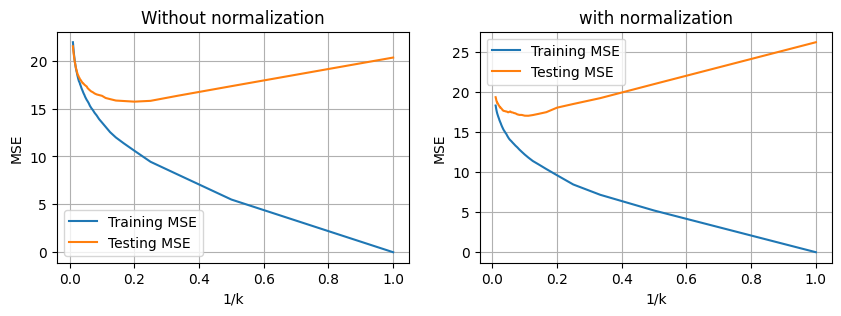

+-----------------------------------+----------+---------------+
| Model                             |   Best K |   Testing MSE |
+===================================+==========+===============+
| KNN Regression w/o normalization  |        5 |       15.7268 |
+-----------------------------------+----------+---------------+
| KNN Regression with normalization |        9 |       17.0337 |
+-----------------------------------+----------+---------------+


In [58]:
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

# knn regression using raw features
train_error, test_error, best_k, min_test_error = knn_regression(train_x, train_y, test_x, test_y)
axs[0] = plot_test_train_knn_regression(axs[0], train_error, test_error, 'Without normalization')

# knn regression using normalised features
train_x_norm = MinMaxScaler().fit_transform(train_x)
test_x_norm = MinMaxScaler().fit_transform(test_x)
train_error, test_error, best_k_norm, min_test_error_norm = knn_regression(train_x_norm, train_y, 
                                                                           test_x_norm, test_y)
axs[1] = plot_test_train_knn_regression(axs[1], train_error, test_error, "with normalization")
plt.show()

result = [["KNN Regression w/o normalization", best_k, min_test_error], 
         ["KNN Regression with normalization", best_k_norm, min_test_error_norm]]
print(tabulate(result, headers = ["Model", "Best K", "Testing MSE"], tablefmt = 'grid'))

## [1j] Compare KNN and Linear

In [60]:
final_result = [["Linear regression with all variables", table[0][2]], 
                ["Linear regression after removing insignicant variables", table[1][2]], 
                ["KNN regression w/o normalization", result[0][2]], 
                ["KNN regression with normalization", result[1][2]]]
print(tabulate(final_result, headers = ["Model", "Testing MSE"], tablefmt = 'grid'))

+--------------------------------------------------------+---------------+
| Model                                                  |   Testing MSE |
+========================================================+===============+
| Linear regression with all variables                   |       18.576  |
+--------------------------------------------------------+---------------+
| Linear regression after removing insignicant variables |       18.642  |
+--------------------------------------------------------+---------------+
| KNN regression w/o normalization                       |       15.7268 |
+--------------------------------------------------------+---------------+
| KNN regression with normalization                      |       17.0337 |
+--------------------------------------------------------+---------------+


<font size="6">Findings</font></br>
* We observed the lowest test MSE with linear regression in $(1h)$ part was $18.576$, while the lowest test mse for KNN regression $15.72$. Thus, by simply observing the MSE of test data, we can say that **KNN regression is a better predictor than linear regression.**

# ISLR: 2.4.1

## [2a] The sample size n is extremely large, and the number of predictors p is small

**Flexible method would perform better than the inflexible models** when n is huge, and the number of predictors p is small. The large n would avoid overfitting, which is the most common problem with flexible methods. Apart from that, when p is small, we need more interactions between the predictors to extract more information and predict/fit in large samples n with less testing error.

## [2b] The number of predictors p is extremely large, and the sample size n is small

**Inflexible method would perform better than the flexible models** when p is extremely large and the number of samples n is small. When the n is small and p is high, it can lead to more variance for the flexible models, that in turn, means overfitting. 

## [2c] The relationship between the predictors and response is highly non-linear

**Flexible method would perform better than the inflexible models** Since the flexible models could have complex interactions between the predictors or quadratic function in the formula, it would be the right fit when there is a non-linearity between predictors and response compared to inflexible models

## [2d] The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high

The high variance in training samples would mean that data has so much noise in it. Hence flexible models is more likely to overfit. **Hence inflexible models would perform better than flexible models.**

# 3 ISLR: 2.4.7

## [3a]  The Euclidean distance between each observation and point X1 = X2 = X3 = 0

Euclidean distance of different observation points from point ($x_1 = 0$, $x_2 = 0$,$x_3 = 0$) is: 

sample 1 = $\sqrt{(3-0)^2 + (0-0)^2 + (0-0)^2}$ = 3

sample 2 = $\sqrt{(2-0)^2 + (0-0)^2 + (0-0)^2}$ = 2

sample 3 = $\sqrt{(3-0)^2 + (1-0)^2 + (0-0)^2}$ = 3.16

sample 4 = $\sqrt{(2-0)^2 + (1-0)^2 + (0-0)^2}$ = 2.2

sample 5 = $\sqrt{(1-0)^2 + (-1-0)^2 + (0-0)^2}$ = 1.41

sample 6 = $\sqrt{(1-0)^2 + (1-0)^2 + (1-0)^2}$ = 1.73

## [3b] What is our prediction with K = 1? Why?

When K = 1, the nearest first neighbouring point is sample point 5. Thus our prediction would be **Green**. 

## [3c] What is our prediction with K = 3? Why?

When K = 3, three nearest neighbouring points are sample point 5, 6 and 2. Sample point 2 and 6 has label Red and sample point 5 has label Green. Thus our prediction would be the majority label **Red**.

## [3d] If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

K-value should be **small**. When K is large, the model would have high bias and less variance because the model would try to predict the feature value based on many neighbors. This would mean that the decision boundary would show more like a linear behavior. In contrast to this, when k is large, the model will have high variance. This would mean that the model with a small K would be highly non-linear.